# Prepare Trained Model for Inference




In [1]:
import numpy as np
import onnxruntime
import torch

from luna16 import augmentations, datasets, dto, modules, settings
from luna16.notebooks import visualizations
from luna16.services import ModelSaver

%matplotlib inline

## Load the Trained Model


In [2]:
model_saver = ModelSaver()
model_name = "DropoutModel"
module_params = modules.DropoutParameters(
    name=model_name,
    in_channels=1,
    conv_channels=8,
    out_features=2,
    n_blocks=4,
    input_dim=(32, 48, 48),
    dropout_rate=0.4,
    block_class=modules.DropoutBlock,
)
module_class = modules.CnnModel
model_type = "Classification"
model_version = "1.0.0"
module = model_saver.load_model(
    name=model_type,
    module_class=module_class,
    version=model_version,
    module_params=module_params,
)
module

CnnModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (luna_blocks): ModuleList(
    (0): DropoutBlock(
      (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (dropout1): Dropout(p=0.4, inplace=False)
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (dropout2): Dropout(p=0.4, inplace=False)
      (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DropoutBlock(
      (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, tr

## Try on a Sample Image


In [3]:
ratio = dto.NoduleRatio(positive=1, negative=1)
transformations: list[augmentations.Transformation] = [
    augmentations.Flip(),
    augmentations.Offset(offset=0.1),
    augmentations.Scale(scale=0.2),
    augmentations.Rotate(),
]
filters: list[augmentations.Filter] = [
    augmentations.Noise(noise=25.0),
]
dataset = datasets.CutoutsDataset(
    ratio=ratio,
    validation_stride=20,
    transformations=transformations,
    filters=filters,
)

[02/22/25 14:59:39] INFO     CutoutsDataset(len=47499, positive_len=77, negative_len=47422,    ]8;id=126134;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py\nodule_cutouts.py]8;;\:]8;id=906730;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py#95\95]8;;\
                             train=True, validation_stride=20)                                                     

In [4]:
positive_cutout = dataset[0]
negative_cutout = dataset[1]
(
    positive_cutout.candidate.shape,
    negative_cutout.candidate.min(),
    negative_cutout.candidate.max(),
)

(torch.Size([1, 32, 48, 48]), tensor(-999.8031), tensor(277.7275))

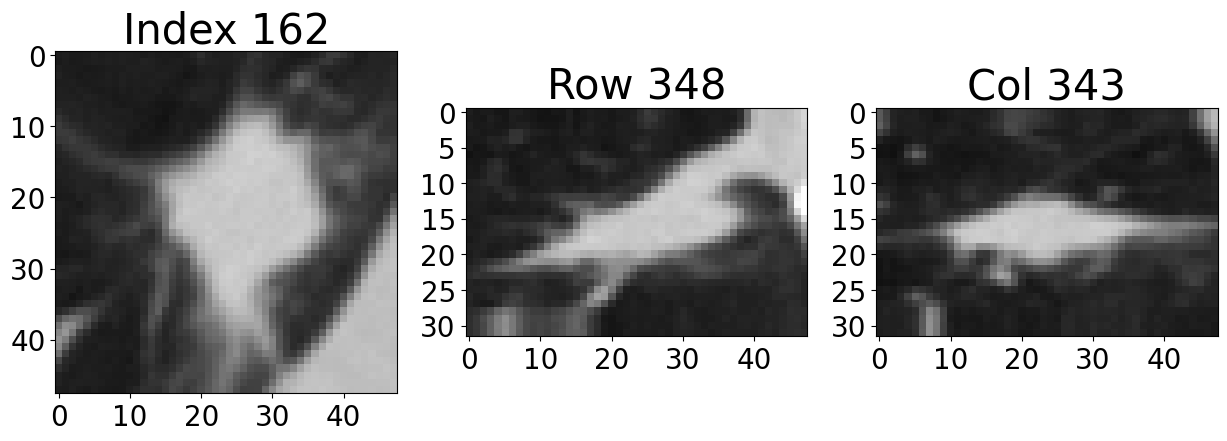

In [5]:
visualizations.plot_cutout(
    positive_cutout.center_irc, positive_cutout.candidate[0].numpy()
)

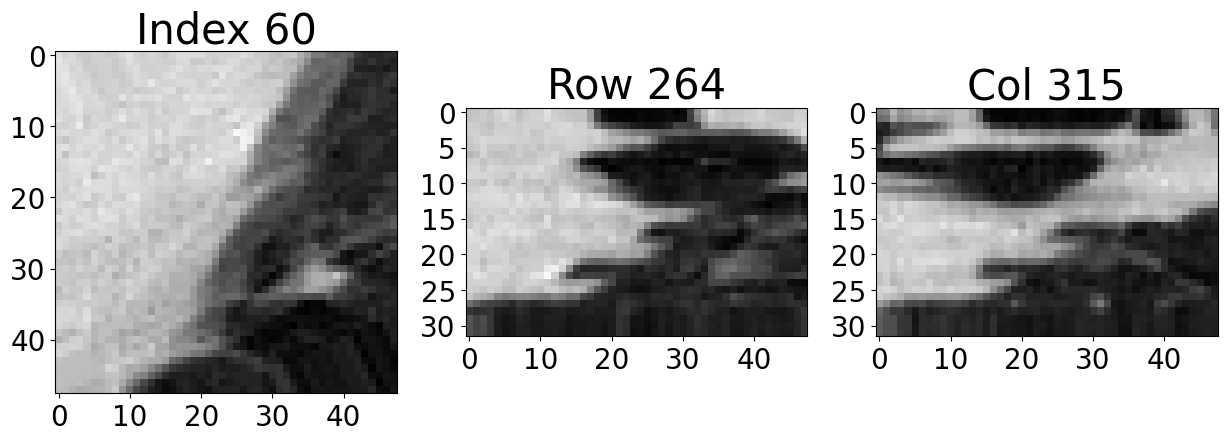

In [6]:
visualizations.plot_cutout(
    negative_cutout.center_irc, negative_cutout.candidate[0].numpy()
)

## Export the Model for Inference

In [7]:
args = (torch.unsqueeze(positive_cutout.candidate, 0),)
compiled_models = settings.MODELS_DIR / "compiled"
compiled_models.mkdir(exist_ok=True)

compiled_model_name = f"{model_type}-{model_name}-{model_version}.onnx"
compiled_model_path = compiled_models / compiled_model_name
torch.onnx.export(
    module,
    args,
    compiled_model_path,
    input_names=["input"],
    output_names=["logits", "probabilities"],
)

## Run Model with ONNX Runtime

In [8]:
session = onnxruntime.InferenceSession(compiled_model_path)
session

We only have one input, the cutout image model will be classifying.

In [9]:
# Get the name of the input node (usually the first input)
input_name = session.get_inputs()[0].name
# Get the expected input shape
input_shape = session.get_inputs()[0].shape
# Get the expected input data type
input_type = session.get_inputs()[0].type

print(f"Input Name: {input_name}")
print(f"Shape: {input_shape}")
print(f"Type: {input_type}")

Input Name: input
Shape: [1, 1, 32, 48, 48]
Type: tensor(float)


Model can output both logits and probabilities. For inference, we will use logits.

In [10]:
output_names = [output.name for output in session.get_outputs()]
output_names

['logits', 'probabilities']

### Inference on Nodule Cutout Image

In [11]:
# Create a dictionary mapping input name to input data
input_feed = {input_name: torch.unsqueeze(positive_cutout.candidate, 0).numpy()}

In [12]:
outputs = session.run(output_names=["logits"], input_feed=input_feed)
outputs

[array([[-2.0776765,  1.8863013]], dtype=float32)]

In [13]:
logits = outputs[0]
predicted_class_index = np.argmax(logits)
(
    logits,
    predicted_class_index,
    "Is Positive" if predicted_class_index == 1 else "Not Nodule",
)

(array([[-2.0776765,  1.8863013]], dtype=float32), np.int64(1), 'Is Positive')

### Inference on Not Nodule Cutout Image

In [14]:
input_feed = {"input": torch.unsqueeze(negative_cutout.candidate, 0).numpy()}
outputs = session.run(output_names=["logits"], input_feed=input_feed)
logits = outputs[0]
predicted_class_index = np.argmax(logits)
(
    logits,
    predicted_class_index,
    "Is Positive" if predicted_class_index == 1 else "Not Nodule",
)

(array([[ 2.5613136, -2.2933455]], dtype=float32), np.int64(0), 'Not Nodule')